# Animating NFL Plays in Plotly

Last Year I made a Notebook that detailed how to animate plays in plotly. This year I updated the code to work with the new data files and added a few quality of life upgrades with end zone colors and different team color options when opponents have similar main colors.

From Last year:
>I was inspired by Nick Wan's Matplotlib GIF visualization to build an animated visualization with Plotly that can animate plays but also show details of the players on the field for a play and additional information like game time, down and distance. Hopefully this is a helpful tool for others during EDA steps of the process.

[Notebook Link](https://www.kaggle.com/code/huntingdata11/animated-and-interactive-nfl-plays-in-plotly)

In [1]:
import pandas as pd
import numpy as np

# Read In csvs
games = pd.read_csv("games.csv")
plays = pd.read_csv("plays.csv")
players = pd.read_csv("players.csv").drop("displayName",axis=1)
week1 = pd.read_csv("tracking_week_1.csv")
tackles = pd.read_csv("tackles.csv")
joined_all = pd.merge(games,plays,how="inner",on = "gameId")
joined_all = pd.merge(joined_all,week1,how="inner",on=["gameId","playId"])
joined_all = pd.merge(joined_all,tackles,how="left",on=["gameId","playId","nflId"])
# left join on players to keep football records
joined_all = pd.merge(joined_all,players,how="left",on = "nflId")
play_focus = 2184
focused_df = joined_all[(joined_all.playId==play_focus)]

# Simple Plotly Graph

From Last Year's Notebook

>If all we want to do is plot out a simple frame for a play in plotly it is very straightforward. We can see the 22 players and the football but dont really have good context as to where they are on the field or what the other situational variables are like down, distance or time in the game. We also aren't making good use of the mouse over features in plotly since right now all they are showing is the x,y position of the player.

Similar to last year's data we can start with a simple plot (this year the team column was changed to club but other than that we are able to still use the same simple visual). Unlike last year where plays ended after a ball was thrown this year the plays start when the ball is about to be caught.

> In this competition, we are not giving all frames of all plays to keep the focus on tackling. There are 3 play types that are included in the data:
> - On pass completions (plays including your first animation), we include 5 frames before the ball is caught to 5 frames after the play ends.
> - On designed rushes/handoffs (plays including your second animation), we include 5 frames before the ball is snapped to 5 frames after the play ends.
> - On QB scrambles (designed pass plays where the QB decides to run instead of throw), we include 5 frames before the QB crosses the line of scrimmage to 5 frames after the play ends.

[source](https://www.kaggle.com/competitions/nfl-big-data-bowl-2024/discussion/447639#2484739)

# Complex Plotly Graph
From Last Year's Notebook:
>For my more complex graph I set a few goals.
>
>Goals:
>
>Animate all frames in a play
>Color player dots with the actual team colors instead of generic home/away colors or having to set different colors each time I run the code
>Add Down, Distance and Situational information to the Animation
>Add Player information in hover/tooltip
>Add Play Description
>Get Colors for every team
>I found a website online with color codes for each NFL team to help personalize the Animations a bit.
>
>Color Codes Found on the following sites:
>
>https://teamcolorcodes.com/nfl-team-color-codes/
>
>https://www.schemecolor.com/american-football.php
>
>Note: Not all color combo's are tested so you may get a weird combination. I could probably work out some color difference and switch to an alternate if they are too close but this is a first pass at it

This year I want to add code to handle the above mentioned note about weird color combinations for certain teams playing eachother.

## Improvements to Color Combinations
Last year I put a pretty simple color palette out and a variety of teams had very similar colors. To try to avoid confusing team color combos this year I am adding nuance to add a second (and in some cases third) color from the logo hex colors website. Also I am adding functionality to display good color combinations that arent too similar.

In [3]:
colors = {
    'ARI':["#97233F","#000000","#FFB612"], 
    'ATL':["#A71930","#000000","#A5ACAF"], 
    'BAL':["#241773","#000000"], 
    'BUF':["#00338D","#C60C30"], 
    'CAR':["#0085CA","#101820","#BFC0BF"], 
    'CHI':["#0B162A","#C83803"], 
    'CIN':["#FB4F14","#000000"], 
    'CLE':["#311D00","#FF3C00"], 
    'DAL':["#003594","#041E42","#869397"],
    'DEN':["#FB4F14","#002244"], 
    'DET':["#0076B6","#B0B7BC","#000000"], 
    'GB' :["#203731","#FFB612"], 
    'HOU':["#03202F","#A71930"], 
    'IND':["#002C5F","#A2AAAD"], 
    'JAX':["#101820","#D7A22A","#9F792C"], 
    'KC' :["#E31837","#FFB81C"], 
    'LA' :["#003594","#FFA300","#FF8200"], 
    'LAC':["#0080C6","#FFC20E","#FFFFFF"], 
    'LV' :["#000000","#A5ACAF"],
    'MIA':["#008E97","#FC4C02","#005778"], 
    'MIN':["#4F2683","#FFC62F"], 
    'NE' :["#002244","#C60C30","#B0B7BC"], 
    'NO' :["#101820","#D3BC8D"], 
    'NYG':["#0B2265","#A71930","#A5ACAF"], 
    'NYJ':["#125740","#000000","#FFFFFF"], 
    'PHI':["#004C54","#A5ACAF","#ACC0C6"], 
    'PIT':["#FFB612","#101820"], 
    'SEA':["#002244","#69BE28","#A5ACAF"], 
    'SF' :["#AA0000","#B3995D"],
    'TB' :["#D50A0A","#FF7900","#0A0A08"], 
    'TEN':["#0C2340","#4B92DB","#C8102E"], 
    'WAS':["#5A1414","#FFB612"], 
    'football':["#CBB67C","#663831"]
}

## Find Color Distances:

Code from: 
- https://stackoverflow.com/a/14097641
- https://stackoverflow.com/a/29643643

In [4]:
def hex_to_rgb_array(hex_color):
    '''take in hex val and return rgb np array'''
    return np.array(tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))) 

def ColorDistance(hex1,hex2):
    '''d = {} distance between two colors(3)'''
    if hex1 == hex2:
        return 0
    rgb1 = hex_to_rgb_array(hex1)
    rgb2 = hex_to_rgb_array(hex2)
    rm = 0.5*(rgb1[0]+rgb2[0])
    d = abs(sum((2+rm,4,3-rm)*(rgb1-rgb2)**2))**0.5
    return d

def ColorPairs(team1,team2):
    color_array_1 = colors[team1]
    color_array_2 = colors[team2]
    # If color distance is small enough then flip color order
    if ColorDistance(color_array_1[0],color_array_2[0])<500:
        return {team1:[color_array_1[0],color_array_1[1]],team2:[color_array_2[1],color_array_2[0]],'football':colors['football']}
    else:
        return {team1:[color_array_1[0],color_array_1[1]],team2:[color_array_2[0],color_array_2[1]],'football':colors['football']}

In [154]:
def animate_play_probs(games,tracking_df,play_df,players):
    
    gameId = tracking_df.gameId.iloc[0]
    playId = tracking_df.playId.iloc[0]
    
    selected_game_df = games[games.gameId==gameId].copy()
    selected_play_df = play_df[(play_df.playId==playId)&(play_df.gameId==gameId)].copy()
    
    tracking_players_df = pd.merge(tracking_df,players,how="left",on = "nflId")
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()

    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()
    
    # get good color combos
    team_combos = list(set(selected_tracking_df.club.unique())-set(["football"]))
    color_orders = ColorPairs(team_combos[0],team_combos[1])
    
    # get play General information 
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    ## Fixing first down marker issue from last year
    if selected_tracking_df.playDirection.values[0] == "right":
        first_down_marker = line_of_scrimmage + selected_play_df.yardsToGo.values[0]
    else:
        first_down_marker = line_of_scrimmage - selected_play_df.yardsToGo.values[0]
    down = selected_play_df.down.values[0]
    quarter = selected_play_df.quarter.values[0]
    gameClock = selected_play_df.gameClock.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    frames = []
    for frameId in sorted_frame_list:
        data = []
        # Add Numbers to Field 
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[53.5-5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add line of scrimage 
        data.append(
            go.Scatter(
                x=[line_of_scrimmage,line_of_scrimmage], 
                y=[0,53.5],
                line_dash='dash',
                line_color='blue',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add First down line 
        data.append(
            go.Scatter(
                x=[first_down_marker,first_down_marker], 
                y=[0,53.5],
                line_dash='dash',
                line_color='yellow',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add Endzone Colors 
        endzoneColors = {0:color_orders[selected_game_df.homeTeamAbbr.values[0]][0],
                         110:color_orders[selected_game_df.visitorTeamAbbr.values[0]][0]}
        for x_min in [0,110]:
            data.append(
                go.Scatter(
                    x=[x_min,x_min,x_min+10,x_min+10,x_min],
                    y=[0,53.5,53.5,0,0],
                    fill="toself",
                    fillcolor=endzoneColors[x_min],
                    mode="lines",
                    line=dict(
                        color="white",
                        width=3
                        ),
                    opacity=1,
                    showlegend= False,
                    hoverinfo ="skip"
                )
            )
        # Set the default marker size and adjust the multiplier for increasing size
        default_marker_size = 10
        size_multiplier = 20  # Adjust the multiplier as needed

        # Plot Players
        for team in selected_tracking_df.club.unique():
            plot_df = selected_tracking_df[(selected_tracking_df.club == team) & (selected_tracking_df.frameId == frameId)].copy()
            if team != "football":
                hover_text_array = []
                for _, player_row in plot_df.iterrows():
                    hover_text_array.append("nflId:{}<br>displayName:{}<br>Player Speed:{} yd/s<br>Tackle Probability: {:.2%}".format(
                        player_row["nflId"],
                        player_row["displayName"],
                        player_row["s"],
                        player_row["prediction"]
                    ))
                    # Update size based on tackle_probability
                    marker_size = default_marker_size + size_multiplier * player_row["prediction"]  # Adjust the multiplier as needed
                    data.append(go.Scatter(
                        x=[player_row["x"]],
                        y=[player_row["y"]],
                        mode='markers',
                        marker=dict(
                            color=color_orders[team][0],
                            line=go.scatter.marker.Line(width=2, color=color_orders[team][1]),
                            size=marker_size,  # Adjust the size based on tackle_probability
                            opacity=0.9,  # Set alpha to 0.5 (transparency)
                        ),
                        name=team,
                        hovertext=hover_text_array,
                        hoverinfo="text"
                    ))
            else:
                data.append(go.Scatter(
                    x=plot_df["x"],
                    y=plot_df["y"],
                    mode='markers',
                    marker=dict(
                        color=color_orders[team][0],
                        line=go.scatter.marker.Line(width=2, color=color_orders[team][1]),
                        size=default_marker_size,
                        opacity=0.9,  # Set alpha to 0.5 (transparency)
                    ),
                    name=team,
                    hoverinfo='none'
                ))



        # add frame to slider
        slider_step = {"args": [
            [frameId],
            {"frame": {"duration": 100, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 0}}
        ],
            "label": str(frameId),
            "method": "animate"}
        sliders_dict["steps"].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=10
    layout = go.Layout(
        autosize=False,
        width=120*scale,
        height=60*scale,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
        title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q"+"<br>"*19+f"{playDescription}",
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )

    fig = go.Figure(
        data=frames[0]["data"],
        layout= layout,
        frames=frames[1:]
    )
    # Create First Down Markers 
    for y_val in [0,53]:
        fig.add_annotation(
                x=first_down_marker,
                y=y_val,
                text=str(down),
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="black"
                    ),
                align="center",
                bordercolor="black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=1
                )
    # Add Team Abbreviations in EndZone's
    for x_min in [0,110]:
        if x_min == 0:
            angle = 270
            teamName=selected_game_df.homeTeamAbbr.values[0]
        else:
            angle = 90
            teamName=selected_game_df.visitorTeamAbbr.values[0]
        fig.add_annotation(
            x=x_min+5,
            y=53.5/2,
            text=teamName,
            showarrow=False,
            font=dict(
                family="Courier New, monospace",
                size=32,
                color="White"
                ),
            textangle = angle
        )
    return fig

In [58]:
model_output = pd.read_csv('model_results.csv')
tracking_1 = pd.read_csv("tracking_week_1.csv")
tracking_2 = pd.read_csv("tracking_week_2.csv")
tracking_3 = pd.read_csv("tracking_week_3.csv")
tracking_4 = pd.read_csv("tracking_week_4.csv")
tracking_5 = pd.read_csv("tracking_week_5.csv")
tracking_6 = pd.read_csv("tracking_week_6.csv")
tracking_7 = pd.read_csv("tracking_week_7.csv")
tracking_8 = pd.read_csv("tracking_week_8.csv")
tracking_9 = pd.read_csv("tracking_week_9.csv")
tracking = pd.concat([tracking_1,tracking_2,tracking_3,tracking_4,tracking_5,tracking_6,tracking_7,tracking_8,tracking_9], axis = 0).reset_index(drop = True)

In [59]:
tracking = tracking.merge(model_output[['gameId','playId','nflId','frameId','prediction']], on=['gameId','playId','nflId','frameId'], how='left')
tracking['prediction'] = tracking['prediction'].fillna(0) # fill offense and football predictions in with 0

gameId  playId    nflId        displayName  frameId  \
1214      2022090800     101  35472.0     Rodger Saffold       19   
1263      2022090800     101  38577.0       Bobby Wagner       19   
1312      2022090800     101  41239.0       Aaron Donald       19   
1361      2022090800     101  42392.0        Mitch Morse       19   
1410      2022090800     101  42816.0          Troy Hill       19   
...              ...     ...      ...                ...      ...   
12187192  2022110700    3787  54476.0        Chris Olave       15   
12187236  2022110700    3787  54541.0       Travis Jones       15   
12187280  2022110700    3787  54606.0  Damarion Williams       15   
12187324  2022110700    3787  55125.0         Lewis Kidd       15   
12187368  2022110700    3787      NaN           football       15   

                                time  jerseyNumber      club playDirection  \
1214      2022-09-08 20:25:10.000000          76.0       BUF          left   
1263      2022-09-08 20:25:10.000000          45.0        LA          left   
1312      2022-09-08 20:25:10.000000          99.0        LA          left   
1361      2022-09-08 20:25:10.000000          60.0       BUF          left   
1410      2022-09-08 20:25:10.000000           2.0        LA          left   
...                              ...           ...       ...           ...   
12187192  2022-11-07 23:06:46.700000          12.0        NO         right   
12187236  2022-11-07 23:06:46.700000          98.0       BAL         right   
12187280  2022-11-07 23:06:46.700000          22.0       BAL         right   
12187324  2022-11-07 23:06:46.700000          66.0        NO         right   
12187368  2022-11-07 23:06:46.700000           NaN  football         right   

                  x          y     s      a   dis       o     dir    event  \
1214      71.660000  30.420000  3.00   1.50  0.31  295.90  321.89  handoff   
1263      68.070000  32.090000  4.92   4.66  0.47   42.01   19.60  handoff   
1312      72.320000  28.990000  4.08   0.40  0.42  338.59   19.81  handoff   
1361      71.140000  31.370000  3.19   0.50  0.33  205.27  322.97  handoff   
1410      64.880000  42.010000  2.20   3.90  0.20   82.72   36.34  handoff   
...             ...        ...   ...    ...   ...     ...     ...      ...   
12187192  21.690000   8.980000  3.62   3.61  0.35   76.70   94.92  handoff   
12187236  21.790000  24.990000  1.41   0.99  0.14  255.73  148.76  handoff   
12187280  32.960000  34.840000  1.02   0.77  0.10  245.93   53.26  handoff   
12187324  20.720000  21.290000  0.75   1.00  0.08  109.96  178.01  handoff   
12187368  16.280001  23.790001  1.28  11.30  0.12     NaN     NaN  handoff   

          prediction  
1214             0.0  
1263             0.0  
1312             0.0  
1361             0.0  
1410             0.0  
...              ...  
12187192         0.0  
12187236         0.0  
12187280         0.0  
12187324         0.0  
12187368         0.0  

[135381 rows x 18 columns]

In [160]:
gameId =  2022102301
    # 2022100202 - okay pass play - but it starts at pass caught not line of scrimmage
    # 2022101606 - good run play - starts at LOS but is pushed OB not tackled
    # 2022100903 - another good run play but pushed OB - long play OTHJER FAVORITE
    # 2022102301 - cool end around play shows probability great MY FAVORITE
playId = 931
    # 2889 - okay pass play - but it starts at pass caught not line of scrimmage
    # 1127 - good run play - starts at LOS but is pushed OB not tackled
    # 390 - another good run play but pushed OB - long play OTHER FAVORITE
    # 931 - cool end around play shows probability great MY FAVORITE
tracking_df = tracking[(tracking['gameId'] == gameId) & (tracking['playId'] == playId)]
tracking_df

gameId  playId    nflId    displayName  frameId  \
8555057  2022102301     931  38588.0  Lavonte David        1   
8555058  2022102301     931  38588.0  Lavonte David        2   
8555059  2022102301     931  38588.0  Lavonte David        3   
8555060  2022102301     931  38588.0  Lavonte David        4   
8555061  2022102301     931  38588.0  Lavonte David        5   
...             ...     ...      ...            ...      ...   
8556823  2022102301     931      NaN       football       73   
8556824  2022102301     931      NaN       football       74   
8556825  2022102301     931      NaN       football       75   
8556826  2022102301     931      NaN       football       76   
8556827  2022102301     931      NaN       football       77   

                               time  jerseyNumber      club playDirection  \
8555057  2022-10-23 13:40:26.099999          54.0        TB         right   
8555058  2022-10-23 13:40:26.200000          54.0        TB         right   
8555059  2022-10-23 13:40:26.299999          54.0        TB         right   
8555060  2022-10-23 13:40:26.400000          54.0        TB         right   
8555061  2022-10-23 13:40:26.500000          54.0        TB         right   
...                             ...           ...       ...           ...   
8556823  2022-10-23 13:40:33.299999           NaN  football         right   
8556824  2022-10-23 13:40:33.400000           NaN  football         right   
8556825  2022-10-23 13:40:33.500000           NaN  football         right   
8556826  2022-10-23 13:40:33.599999           NaN  football         right   
8556827  2022-10-23 13:40:33.700000           NaN  football         right   

                 x          y     s     a   dis       o     dir   event  \
8555057  38.650000  31.200000  0.00  0.00  0.01  276.66  307.55     NaN   
8555058  38.650000  31.190000  0.00  0.00  0.01  275.97  296.91     NaN   
8555059  38.650000  31.190000  0.00  0.00  0.01  275.97  291.15     NaN   
8555060  38.650000  31.170000  0.00  0.00  0.02  274.60  268.28     NaN   
8555061  38.660000  31.140000  0.02  0.59  0.03  269.54  175.08     NaN   
...            ...        ...   ...   ...   ...     ...     ...     ...   
8556823  31.379999  49.959999  1.59  4.54  0.17     NaN     NaN  tackle   
8556824  31.360001  50.080002  1.09  4.16  0.12     NaN     NaN     NaN   
8556825  31.320000  50.160000  0.70  3.66  0.08     NaN     NaN     NaN   
8556826  31.280001  50.200001  0.43  3.39  0.06     NaN     NaN     NaN   
8556827  31.250000  50.209999  0.32  2.90  0.04     NaN     NaN     NaN   

         prediction  
8555057         0.0  
8555058         0.0  
8555059         0.0  
8555060         0.0  
8555061         0.0  
...             ...  
8556823         0.0  
8556824         0.0  
8556825         0.0  
8556826         0.0  
8556827         0.0  

[1771 rows x 18 columns]

In [161]:
animate_play_probs(games,tracking_df,plays,players).show() 

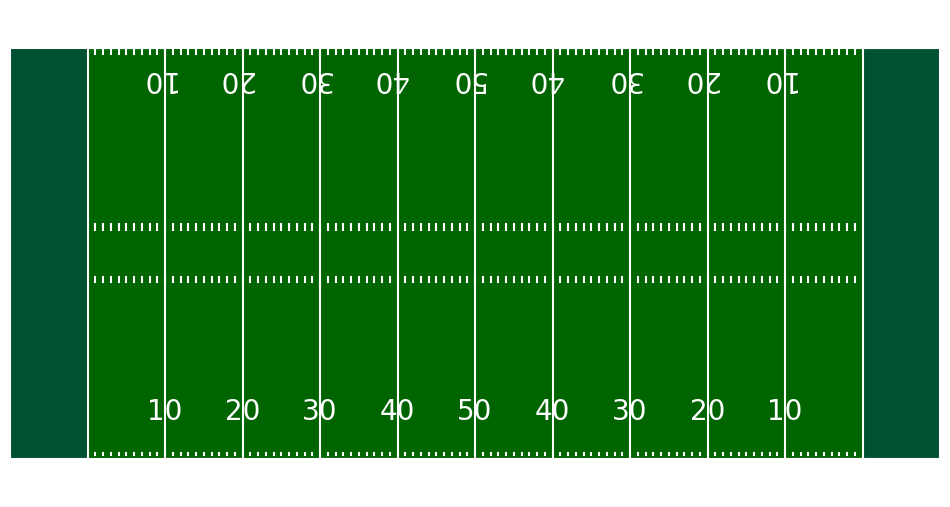

In [61]:
%run Model_Prediction_visualization_functions.ipynb


In [148]:
softmax_tracking = softmax(tracking_df)
softmax_tracking = softmax_tracking.drop(columns='prediction').rename(columns={'softmax_probs':'prediction'})
softmax_tracking

gameId  playId    nflId          displayName  frameId  \
8555057  2022102301     931  38588.0        Lavonte David        1   
8555134  2022102301     931  40074.0     William Gholston        1   
8555211  2022102301     931  42560.0  Rakeem Nunez-Roches        1   
8555288  2022102301     931  43354.0          Carl Nassib        1   
8555365  2022102301     931  44876.0         Taylor Moton        1   
...             ...     ...      ...                  ...      ...   
8556519  2022102301     931  53512.0        Tommy Tremble       77   
8556596  2022102301     931  53555.0        Chuba Hubbard       77   
8556673  2022102301     931  54471.0          Ikem Ekwonu       77   
8556750  2022102301     931  54622.0        Zyon McCollum       77   
8556827  2022102301     931      NaN             football       77   

                               time  jerseyNumber      club playDirection  \
8555057  2022-10-23 13:40:26.099999          54.0        TB         right   
8555134  2022-10-23 13:40:26.099999          92.0        TB         right   
8555211  2022-10-23 13:40:26.099999          56.0        TB         right   
8555288  2022-10-23 13:40:26.099999          94.0        TB         right   
8555365  2022-10-23 13:40:26.099999          72.0       CAR         right   
...                             ...           ...       ...           ...   
8556519  2022-10-23 13:40:33.700000          82.0       CAR         right   
8556596  2022-10-23 13:40:33.700000          30.0       CAR         right   
8556673  2022-10-23 13:40:33.700000          79.0       CAR         right   
8556750  2022-10-23 13:40:33.700000          27.0        TB         right   
8556827  2022-10-23 13:40:33.700000           NaN  football         right   

             x          y     s     a   dis       o     dir event  prediction  
8555057  38.65  31.200000  0.00  0.00  0.01  276.66  307.55   NaN    0.043478  
8555134  35.40  26.770000  0.00  0.00  0.00  209.43  265.16   NaN    0.043478  
8555211  35.19  32.730000  0.03  0.03  0.01   28.98  192.48   NaN    0.043478  
8555288  35.40  25.030000  0.02  0.02  0.01  239.10  356.28   NaN    0.043478  
8555365  33.65  26.520000  0.00  0.00  0.01  224.79  259.26   NaN    0.043478  
...        ...        ...   ...   ...   ...     ...     ...   ...         ...  
8556519  38.82  29.550000  4.01  2.31  0.41   39.02   33.42   NaN    0.043478  
8556596  31.72  15.170000  1.63  0.26  0.16   29.79   21.89   NaN    0.043478  
8556673  41.22  52.300000  4.73  3.19  0.49  317.51    5.37   NaN    0.043478  
8556750  39.43  47.690000  4.90  4.08  0.51  298.18  334.61   NaN    0.043478  
8556827  31.25  50.209999  0.32  2.90  0.04     NaN     NaN   NaN    0.043478  

[1771 rows x 18 columns]